In [7]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
import os

In [5]:
# Population data and the census data, also extract the total and studied attributes
folder_loc = "data"
to_analyse_data = {
    # "SAA_hhsz_rm30": "SAA_HH_oriseed_IPL_abs_hhsz_first_no_penal_rm0_add_zero_cells.csv",
    # "SAA_hhsz_rm0": "SAA_HH_oriseed_IPL_abs_hhsz_first_no_penal_rm30_add_zero_cells.csv",
    # "SAA_hhsz_zerocellstill": "SAA_HH_oriseed_IPL_abs_hhsz_first_no_penal_rm30_missing_zero_cells.csv",
    "SAA_BN_pool": "SAA_HH_paper_BN_IPL_ordered_rm30_2.csv",
    "SAA_seed_addzero": "SAA_HH_paper_oriseed_IPL_ordered_rm30_addzero.csv",
    "SAA_seed_misszero": "SAA_HH_paper_oriseed_IPL_ordered_rm30_misszero.csv",
    "IPF_normal": "IPF_using_normals_seed.csv",
    "IPF_fromBN": "IPF_BN_pool2.csv",
    "seed": "hh_sample_ipu.csv", # Main one always there
}
assert "seed" in to_analyse_data
atts = {'dwelltype', 'hhinc', 'hhsize', 'owndwell', 'totalvehs'}

In [8]:
# Reading the file to df
processed_analyse_data = {name: pd.read_csv(os.path.join(folder_loc, file)) for name, file in to_analyse_data.items() if name != "seed"}

C:\Users\dlaa0001\AppData\Local\Temp\ipykernel_23400\240776870.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  processed_analyse_data = {name: pd.read_csv(os.path.join(folder_loc, file)) for name, file in to_analyse_data.items() if name != "seed"}


In [9]:
seed = pd.read_csv(os.path.join(folder_loc, to_analyse_data["seed"]))

In [26]:
def get_jsd(att, df, seed):
    sum_df = df[att].value_counts(normalize=True)
    sum_seed = seed[att].value_counts(normalize=True)
    # if att == "hhinc" and "Negative income" in sum_df.index:
    #     sum_df = sum_df.drop(index="Negative income")
    p, q = sum_df.align(sum_seed, fill_value=0)

    # Convert to NumPy arrays
    p_array = p.to_numpy()
    q_array = q.to_numpy()

    # Compute Jensen-Shannon Distance
    js_distance = jensenshannon(p_array, q_array)
    return js_distance
    # print(f"Jensen-Shannon Distance for {att}: {js_distance}")

In [27]:
updated_results = {}
for name, df in processed_analyse_data.items():
    hold = {}
    for att in atts:
        hold[att] = get_jsd(att, df, seed)
    updated_results[name] = pd.Series(hold)

In [29]:
last_order = ["hhsize", "totalvehs", "hhinc", "dwelltype", "owndwell"]
jsd_results = pd.DataFrame(updated_results).reindex(last_order)
jsd_results

,SAA_BN_pool,SAA_seed_addzero,SAA_seed_misszero,IPF_normal,IPF_fromBN
hhsize,0.157655,0.075458,0.074765,0.069133,0.075346
totalvehs,0.043038,0.043108,0.042754,0.041844,0.043243
hhinc,0.187654,0.187553,0.180602,0.180920,0.187525
dwelltype,0.117351,0.117091,0.117044,0.117088,0.117315
owndwell,0.091831,0.091189,0.091235,0.089448,0.092411


<Axes: >

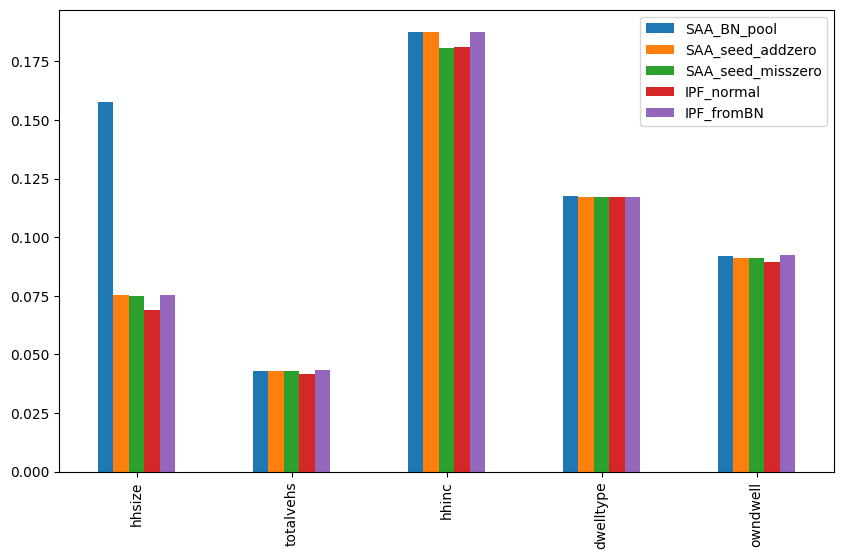

In [30]:
jsd_results.plot(kind='bar', figsize=(10, 6))